In [1]:
import sys
if "/Users/raymond/code/FinalProject563" not in sys.path:
    sys.path.append("/Users/raymond/code/FinalProject563")

import time
import torch
import random
import numpy as np
import pandas

import connect_four
import mcts
import connect_net
import connect_plot

In [2]:
boards = np.load("/Users/raymond/code/FinalProject563/data/move8_boards.npy")
winners = np.load("/Users/raymond/code/FinalProject563/data/move8_winner.npy")

In [3]:
total_num = len(boards)
train_num = int(total_num * 0.8)
val_num = int(total_num * 0.1)
test_num = total_num - train_num - val_num
print(total_num, train_num, val_num, test_num)

shuffled_indexes = list(range(total_num))
random.shuffle(shuffled_indexes)

67557 54045 6755 6757


In [4]:
train_vals = torch.Tensor(boards[shuffled_indexes[:train_num]]).unsqueeze(1)
valid_vals = torch.Tensor(boards[shuffled_indexes[train_num:train_num+val_num]]).unsqueeze(1)
test_vals = torch.Tensor(boards[shuffled_indexes[train_num+val_num:]]).unsqueeze(1)

train_targ = torch.Tensor(winners[shuffled_indexes[:train_num]])
valid_targ = torch.Tensor(winners[shuffled_indexes[train_num:train_num+val_num]])
test_targ = torch.Tensor(winners[shuffled_indexes[train_num+val_num:]])
print(len(train_vals), len(valid_vals), len(test_vals))

54045 6755 6757


In [5]:
nnet = connect_net.ConnectNet()
optimizer = torch.optim.Adam(nnet.parameters(), lr=0.001)
loss_fn = torch.nn.MSELoss(reduction="sum")
l2_lambda = 1

In [6]:
losses_train = []
losses_validation = []

In [7]:
for i in range(400):
    start_time = time.time()
    train_v, proba = nnet(train_vals)
    if torch.isnan(proba).any():
        print("Found nan")
        break
    reg_loss = l2_lambda * sum(p.square().sum() for p in nnet.parameters())
    
    train_loss = loss_fn(train_v, train_targ)
    train_loss = train_loss + reg_loss
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    losses_train.append(train_loss.item())

    valid_v, _ = nnet(valid_vals)
    val_loss = loss_fn(valid_v, valid_targ).item()
    losses_validation.append(val_loss)
    if i % 10 == 0:
        print(f"EPOCH::{i}  LOSS::{val_loss:.4f}  TIME::{time.time() - start_time:.4f}")

EPOCH::0  LOSS::5308.5020  TIME::3.4890
EPOCH::10  LOSS::4328.3184  TIME::3.3811
EPOCH::20  LOSS::3374.7939  TIME::3.4249
EPOCH::30  LOSS::3021.4893  TIME::3.4552
EPOCH::40  LOSS::2949.6306  TIME::3.4964
EPOCH::50  LOSS::2845.3955  TIME::3.5470
EPOCH::60  LOSS::2777.8081  TIME::3.5185
EPOCH::70  LOSS::2719.4597  TIME::3.4541
EPOCH::80  LOSS::2651.2227  TIME::3.5890
EPOCH::90  LOSS::2573.5183  TIME::3.5304
EPOCH::100  LOSS::2487.5679  TIME::3.4522
EPOCH::110  LOSS::2406.4785  TIME::3.4461
EPOCH::120  LOSS::2358.9465  TIME::3.4400
EPOCH::130  LOSS::2278.1689  TIME::3.4463
EPOCH::140  LOSS::2215.6758  TIME::3.5121
EPOCH::150  LOSS::2158.7795  TIME::3.4316
EPOCH::160  LOSS::2099.5566  TIME::3.4861
EPOCH::170  LOSS::2052.5083  TIME::3.4769
EPOCH::180  LOSS::2029.2539  TIME::3.4398
EPOCH::190  LOSS::1971.3781  TIME::3.4548
EPOCH::200  LOSS::1937.9115  TIME::3.4821
EPOCH::210  LOSS::1920.6088  TIME::3.5097
EPOCH::220  LOSS::1878.0483  TIME::3.5086
EPOCH::230  LOSS::2041.5765  TIME::3.4421
EPO

<AxesSubplot:>

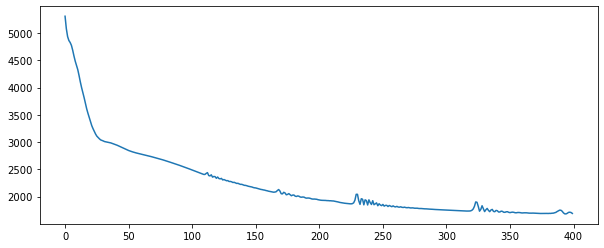

In [8]:
pandas.Series(losses_validation).plot(figsize=(10, 4))

In [9]:
connect_net.save_model(nnet, "../models/pretrain01.model")